In [1]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn
from imblearn.under_sampling import RandomUnderSampler


In [2]:
class Dataset():
    def __init__(self):
        
        # whole dataset
        df = pd.read_csv('dataset_2.csv')
        self.y = df['K2Q31A']
        self.X = df.drop(columns='K2Q31A')

        # chi square
        self.chi = pd.read_csv('chi.csv')
        self.chi = self.chi.loc[self.chi['Dr Sheikhy'] == 'Y']['feature name']
        
        # fisher's score
        self.fisher = pd.read_csv('fisher.csv')
        self.fisher = self.fisher.loc[self.fisher['Dr Sheikhy'] == 'Y']['Feature Name']

        # information gain
        self.inf = pd.read_csv('inf-gain.csv')
        self.inf = self.inf.loc[self.inf['Dr Sheikhy'] == 'Y']['Feature Name']

        # corelation
        self.cor = pd.read_csv('cor.csv')
        self.cor = self.cor.iloc[:,[0, 14]].where(self.cor.iloc[:,14] == 'Y').dropna().iloc[:, 0]

    def return_dataset(self)->pd.DataFrame:
        return self.X, self.y

    def return_chi(self)->pd.Series:
        return self.chi
    
    def return_fisher(self)->pd.Series:
        return self.fisher
    
    def return_inf(self)->pd.Series:
        return self.inf
    
    def return_cor(self)->pd.Series:
        return self.cor
    
    def return_intersection_chi_fisher(self) -> list:
        return list(set(self.chi.tolist()) & set(self.fisher.tolist()))

    def return_intersection_chi_inf(self) -> list:
        return list(set(self.chi.tolist()) & set(self.inf.tolist()))

    def return_intersection_chi_cor(self) -> list:
        return list(set(self.chi.tolist()) & set(self.cor.tolist()))
    
    def return_intersection_fisher_inf(self) -> list:
        return list(set(self.fisher.tolist()) & set(self.inf.tolist()))

    def return_intersection_fisher_cor(self) -> list:
        return list(set(self.fisher.tolist()) & set(self.cor.tolist()))

    def return_intersection_inf_cor(self) -> list:
        return list(set(self.inf.tolist()) & set(self.cor.tolist()))

    
    

In [ ]:
class Model():
    def __init__(self):
        pass

    def fit_xgboost(self):
        pass

    def fit_adaboost(self):
        pass

    def fit_gradient_boost(self):
        pass

    def fit_random_forest(self):
        pass
    
    def fit_svm(self):
        pass

In [48]:
dataset = Dataset()
X, y = dataset.return_dataset()
X.shape, y.shape
b = dataset.return_cor()
b
a = dataset.return_intersection_fisher_cor()
a

['K4Q23',
 'K2Q33A',
 'MEMORYCOND',
 'K4Q22_R',
 'K2Q60A',
 'K2Q34A',
 'TOTFEMALE',
 'ACE3',
 'K2Q36A',
 'K2Q30A',
 'K2Q37A',
 'SC_K2Q22',
 'K2Q35A',
 'ACE8',
 'K7Q70_R',
 'ACE11',
 'K2Q40A']

In [10]:

# selected_cols_chi_fisher = perfect.loc[:, df.columns.isin(chi_fisher)]
# selected_cols_chi_fisher.shape

# selected_cols_inf_fisher = perfect.loc[:, df.columns.isin(inf_fisher)]
# selected_cols_inf_fisher.shape

# selected_cols_inf_chi = perfect.loc[:, df.columns.isin(inf_chi)]
# selected_cols_inf_chi.shape

# selected_cols_chi_fisher_inf = perfect.loc[:, df.columns.isin(chi_fisher_inf)]
# selected_cols_chi_fisher_inf.shape

# selected_cols_chi_fisher_inf_intersect = perfect.loc[:, df.columns.isin(chi_fisher_inf_intersect)]
# selected_cols_chi_fisher_inf.shape

# selected_cols_all = perfect.loc[:, df.columns.isin(all)]
# selected_cols_chi_fisher_inf.shape

# selected_cols_inf_chi_inter = perfect.loc[:, df.columns.isin(inf_chi_intersect)]
# selected_cols_chi_fisher_inf.shape

# target_perfect.shape

# selected_cols_inf_chi_inter.shape

(8532, 24)

### under sampling

In [11]:

# selected_cols_inf_chi = df.loc[:, df.columns.isin(inf_chi_intersect)]
# selected_cols_inf_chi.shape
# y.shape

(27449,)

# XGBOOST

In [66]:

no_iter = 150
xgboost_score_no_iter = list()

for i in range(no_iter):

    undersample = RandomUnderSampler(sampling_strategy='majority')

    X_shuffled, y_shuffled = undersample.fit_resample(selected_cols_inf_chi, y)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    
    y_train = -(y_train - 2)
    y_test = -(y_test - 2)

    classifiers = [
        XGBClassifier(max_depth=5,
            learning_rate=0.01,
            n_estimators=100,
            objective='binary:logistic',
            random_state=42)
    ]

    # scores = []
    # times = []
    # iterate over the classifiers and fit them to the training data
    for clf in classifiers:
        # start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        end_time = time.time()
        # time0 = end_time - start_time
        # times.append(time0)
        
        # print(type(clf).__name__, "Accuracy:", accuracy, 'time: ', time0)
        # score = accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        xgboost_score_no_iter.append(score)

In [67]:
xgboost_score_no_iter_np = np.array(xgboost_score_no_iter)
xgboost_score_no_iter_mean = xgboost_score_no_iter_np.mean()

xgboost_result = [xgboost_score_no_iter_np.mean(), xgboost_score_no_iter_np.max(), \
                  xgboost_score_no_iter_np.min(), xgboost_score_no_iter_np.std()]
xgboost_result

[0.8635891427455576,
 0.8799062683069713,
 0.849443468072642,
 0.005739626035014794]

(array([ 4.,  0., 12., 20., 30., 33., 24., 18.,  5.,  4.]),
 array([0.84475688, 0.84797891, 0.85120094, 0.85442296, 0.85764499,
        0.86086702, 0.86408905, 0.86731107, 0.8705331 , 0.87375513,
        0.87697715]),
 <BarContainer object of 10 artists>)

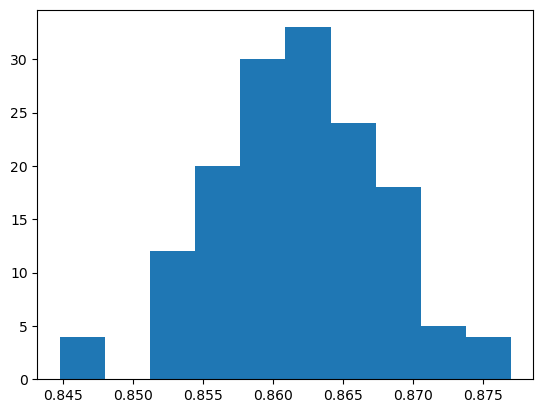

In [35]:
plt.hist(xgboost_score_no_iter)

# ADABOOST

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from xgboost import XGBClassifier

no_iter = 150
adaBoost_score_no_iter = list()

for i in range(no_iter):
    # idx = np.random.permutation(len(perfect))
    # # X_shuffled, y_shuffled = perfect.iloc[idx], target_perfect.iloc[idx]
    # X_shuffled, y_shuffled = perfect.loc[:, df.columns.isin(selected_cols_inf_chi_inter)]\
    # .iloc[idx], target_perfect.iloc[idx]
    X_shuffled, y_shuffled = undersample.fit_resample(selected_cols_inf_chi, y)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    y_train = -(y_train - 2)
    y_test = -(y_test - 2)

    classifiers = [
        # RandomForestClassifier(),
        # SVC(),
        AdaBoostClassifier()
        # GradientBoostingClassifier(),
    #     XGBClassifier(max_depth=5,
    #         learning_rate=0.1,
    #         n_estimators=100,
    #         objective='binary:logistic',
    #         random_state=42)
    ]

    # scores = []
    # times = []
    # iterate over the classifiers and fit them to the training data
    for clf in classifiers:
        # start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        end_time = time.time()
        # time0 = end_time - start_time
        # times.append(time0)
        
        # print(type(clf).__name__, "Accuracy:", accuracy, 'time: ', time0)
        # score = accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        adaBoost_score_no_iter.append(score)

In [ ]:
# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [46]:
adaBoost_score_no_iter_np = np.array(adaBoost_score_no_iter)
adaBoost_score_no_iter_mean = adaBoost_score_no_iter_np.mean()

adaBoost_result = [adaBoost_score_no_iter_np.mean(), adaBoost_score_no_iter_np.max(), \
                  adaBoost_score_no_iter_np.min(), adaBoost_score_no_iter_np.std()]
adaBoost_result

[0.8565241163835189, 0.872290568248389, 0.836555360281195, 0.00557812550034245]

# GRADIENT BOOSTING

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from xgboost import XGBClassifier

no_iter = 150
GradientBoostingClassifier_score_no_iter = list()

for i in range(no_iter):
    # idx = np.random.permutation(len(perfect))
    # # X_shuffled, y_shuffled = perfect.iloc[idx], target_perfect.iloc[idx]
    # X_shuffled, y_shuffled = perfect.loc[:, df.columns.isin(selected_cols_inf_chi_inter)]\
    # .iloc[idx], target_perfect.iloc[idx]

    # X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    X_shuffled, y_shuffled = undersample.fit_resample(selected_cols_inf_chi, y)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    y_train = -(y_train - 2)
    y_test = -(y_test - 2)

    classifiers = [
        # RandomForestClassifier(),
        # SVC(),
        # AdaBoostClassifier()
        GradientBoostingClassifier()
    #     XGBClassifier(max_depth=5,
    #         learning_rate=0.1,
    #         n_estimators=100,
    #         objective='binary:logistic',
    #         random_state=42)
    ]

    # scores = []
    # times = []
    # iterate over the classifiers and fit them to the training data
    for clf in classifiers:
        # start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        end_time = time.time()
        # time0 = end_time - start_time
        # times.append(time0)
        
        # print(type(clf).__name__, "Accuracy:", accuracy, 'time: ', time0)
        # score = accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        GradientBoostingClassifier_score_no_iter.append(score)

In [50]:
GradientBoostingClassifier_score_no_iter_np = np.array(GradientBoostingClassifier_score_no_iter)
GradientBoostingClassifier_score_no_iter_mean = GradientBoostingClassifier_score_no_iter_np.mean()

GradientBoostingClassifier_result = [GradientBoostingClassifier_score_no_iter_np.mean(), GradientBoostingClassifier_score_no_iter_np.max(), \
                  GradientBoostingClassifier_score_no_iter_np.min(), GradientBoostingClassifier_score_no_iter_np.std()]
GradientBoostingClassifier_result

[0.8636360085920717,
 0.8763913298183948,
 0.8453427065026362,
 0.005744311882834405]

# SVM

In [53]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import time


no_iter = 150
SVM_score_no_iter = list()

for i in range(no_iter):
    undersample = RandomUnderSampler(sampling_strategy='majority')
    # idx = np.random.permutation(len(perfect))
    # # X_shuffled, y_shuffled = perfect.iloc[idx], target_perfect.iloc[idx]
    # X_shuffled, y_shuffled = perfect.loc[:, df.columns.isin(selected_cols_inf_chi_inter)]\
    # .iloc[idx], target_perfect.iloc[idx]

    # X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    X_shuffled, y_shuffled = undersample.fit_resample(selected_cols_inf_chi, y)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    y_train = -(y_train - 2)
    y_test = -(y_test - 2)

    classifiers = [
        # RandomForestClassifier()
        SVC()
        # AdaBoostClassifier()
        # GradientBoostingClassifier()
    #     XGBClassifier(max_depth=5,
    #         learning_rate=0.1,
    #         n_estimators=100,
    #         objective='binary:logistic',
    #         random_state=42)
    ]

    # scores = []
    # times = []
    # iterate over the classifiers and fit them to the training data
    for clf in classifiers:
        # start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        end_time = time.time()
        # time0 = end_time - start_time
        # times.append(time0)
        
        # print(type(clf).__name__, "Accuracy:", accuracy, 'time: ', time0)
        # score = accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        SVM_score_no_iter.append(score)

In [54]:
SVM_score_no_iter_np = np.array(SVM_score_no_iter)
SVM_score_no_iter_mean = SVM_score_no_iter_np.mean()

SVM_result = [SVM_score_no_iter_np.mean(), SVM_score_no_iter_np.max(), \
                  SVM_score_no_iter_np.min(), SVM_score_no_iter_np.std()]
SVM_result

[0.8492520991993752,
 0.8611599297012302,
 0.8330404217926186,
 0.005687211454896837]

# RANDOM FOREST

In [47]:

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import time


no_iter = 150
RandomForestClassifier_score_no_iter = list()

for i in range(no_iter):
    # idx = np.random.RandomState(seed=42).permutation(len(perfect))
    # # X_shuffled, y_shuffled = perfect.iloc[idx], target_perfect.iloc[idx]
    # X_shuffled, y_shuffled = perfect.loc[:, df.columns.isin(selected_cols_inf_chi_inter)]\
    # .iloc[idx], target_perfect.iloc[idx]
    X_shuffled, y_shuffled = undersample.fit_resample(selected_cols_inf_chi, y)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    y_train = -(y_train - 2)
    y_test = -(y_test - 2)

    classifiers = [
        RandomForestClassifier()
        # SVC()
        # AdaBoostClassifier()
        # GradientBoostingClassifier()
    #     XGBClassifier(max_depth=5,
    #         learning_rate=0.1,
    #         n_estimators=100,
    #         objective='binary:logistic',
    #         random_state=42)
    ]

    # scores = []
    # times = []
    # iterate over the classifiers and fit them to the training data
    for clf in classifiers:
        # start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        end_time = time.time()
        # time0 = end_time - start_time
        # times.append(time0)
        
        # print(type(clf).__name__, "Accuracy:", accuracy, 'time: ', time0)
        # score = accuracy_score(y_test, y_pred)
        score = accuracy_score(y_test, y_pred)
        RandomForestClassifier_score_no_iter.append(score)

In [48]:
RandomForestClassifier_score_no_iter_np = np.array(RandomForestClassifier_score_no_iter)
RandomForestClassifier_score_no_iter_mean = RandomForestClassifier_score_no_iter_np.mean()

RandomForestClassifier_result = [RandomForestClassifier_score_no_iter_np.mean(), RandomForestClassifier_score_no_iter_np.max(), \
                  RandomForestClassifier_score_no_iter_np.min(), RandomForestClassifier_score_no_iter_np.std()]
RandomForestClassifier_result

[0.8528412419449326,
 0.8640890451083773,
 0.8394844756883422,
 0.005496756464318646]